# Good Seed

## 1-Overview

Good Seed, a supermarket chain, is interested in using Data Science to ensure compliance with alcohol laws by preventing alcohol sales to underage individuals. I’m tasked with evaluating the feasibility of this approach. Each store has cameras at checkout counters, programmed to activate when someone purchases alcohol. Using computer vision, I aim to estimate customers' ages from these photos. My objective is to build and evaluate a model capable of verifying age. To start, I’ll work with a dataset of labeled photos, each indicating the person’s age, allowing me to train and test the model effectively.

## 2-Initialization

Imports in Jupyter notebooks allow users to access external libraries for extended functionality and facilitate code organization by declaring dependencies at the beginning of the notebook, ensuring clear and efficient development.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import inspect
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

1. **Pandas**: is a Python library for data manipulation and analysis, providing data structures like DataFrames for managing labeled data.
2. **Matplotlib**: is a Python library for creating static, interactive, and animated visualizations, offering a flexible environment for plotting data.
3. **Seaborn**: is a Python library built on Matplotlib that simplifies the creation of statistical visualizations, offering tools for drawing attractive and informative graphics.
4. **Inspect**: is to examine something carefully, often to assess its quality, condition, or discover specific details.
5. **TensorFlow**: is a Python library for building and training machine learning models, offering tools for deep learning and neural networks with efficient computation on various hardware.


## 3-Load Data

The dataset for this project is stored on the TripleTen server in the `/datasets/faces/` directory, which includes a `final_files` folder with 7,600 images and a `labels.csv` file containing `file_name` and `real_age` columns. Given the large file size, downloading or storing these files locally or on GitHub is impractical, so I’ll access the data directly from the server. To optimize memory use, I’ll leverage `ImageDataGenerator` to load images in batches rather than all at once. This technique, covered in Chapter 3, Lesson 7 of the course materials, allows me to manage the dataset effectively without overloading computational resources.

In [2]:
labels_path = '/datasets/faces/labels.csv'
df = pd.read_csv(labels_path)
df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


The `labels.csv` file contains two columns: `file_name`, which identifies each specific photo, and `real_age`, which indicates the age of the person in each photo.

## 4-EDA

With only two columns, analyzing the data is straightforward.

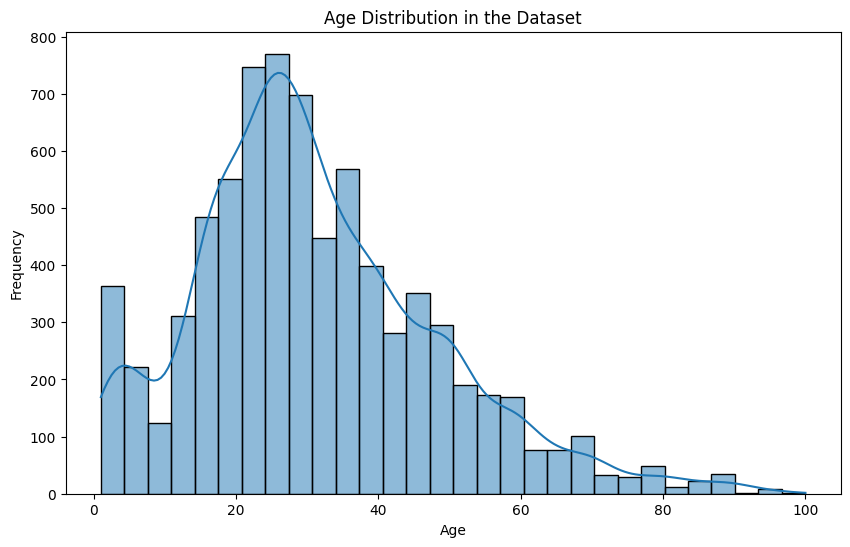

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['real_age'], bins=30, kde=True)
plt.title('Age Distribution in the Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The histogram shows the age distribution in a dataset, with ages on the x-axis (0 to 100) and frequency on the y-axis. Most individuals fall between ages 10 and 30, peaking around the early 20s, and the frequency decreases steadily with age, indicating a right-skewed distribution. The smooth line overlay highlights this trend, suggesting the dataset contains predominantly younger to middle-aged individuals with fewer older ones.

## 5-Modelling

I will define the essential functions needed to train my model on a GPU and create a single script that includes these functions along with an initialization section.

To streamline this process, I can define the functions in this notebook and use a pre-written code in the next section to automatically compile the script.

In [5]:
def load_train(path):
    # Define the ImageDataGenerator for training
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen_flow = train_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    return train_gen_flow

The `load_train` function prepares a data generator for training images from a given directory path. It uses Keras's `ImageDataGenerator` to rescale pixel values to the range [0, 1] by dividing by 255 and applies a 20% validation split. The `flow_from_directory` method creates a generator that loads images in batches of 32, resizes them to 224x224 pixels, and is configured for binary classification (`class_mode='binary'`). This generator, `train_gen_flow`, is returned by the function and can be used to load and preprocess images in batches during model training.

In [6]:
def load_test(path):
    # Define the ImageDataGenerator for validation
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_gen_flow = test_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )
    return test_gen_flow

The `load_test` function creates a data generator for validation images from a specified directory path. It uses Keras's `ImageDataGenerator` with rescaling, dividing pixel values by 255 to normalize them to the range [0, 1], and applies a 20% split to separate validation data. The `flow_from_directory` method is used to load images in batches of 32, resize them to 224x224 pixels, and set up the generator for binary classification (`class_mode='binary`). The generator uses the 'validation' subset to ensure only the validation portion of the data is loaded, making `test_gen_flow` suitable for evaluating a model's performance on unseen data.

In [7]:
def create_model(input_shape=(224, 224, 3)):
    model = Sequential([
        ResNet50(weights='imagenet', include_top=False, input_shape=input_shape),
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])
    return model

The `create_model` function builds a CNN for image regression tasks. It uses `ResNet50` (pre-trained on ImageNet) as a feature extractor, excluding its top layers. After `ResNet50`, it adds `GlobalAveragePooling2D`, `Flatten`, a dense layer with 256 units (ReLU activation), and a `Dropout` layer (0.5) to prevent overfitting. The final layer has a single neuron with a `linear` activation for regression. The model is compiled with the Adam optimizer (learning rate of 0.0001) and Mean Absolute Error (`mae`) as the loss and metric. It returns the compiled model, ready for training.

In [8]:
def train_model(model, train_data, test_data, batch_size=32, epochs=20, steps_per_epoch=None, validation_steps=None):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    return model

The `train_model` function trains a given model using provided training and validation data. It calls the model's `fit` method, using `train_data` as the training data and `test_data` for validation. The training process runs for a specified number of `epochs` (default 20) with an optional `batch_size` (default 32), and optionally accepts `steps_per_epoch` and `validation_steps` to control the number of steps per epoch and validation. The function stores the training history but returns only the trained model. This setup allows flexible training and validation configurations, suitable for custom data generators.

### 5.1-Prepare the Script to Run on the GPU Platform

Once I’ve defined the necessary functions, I can compile a script for the GPU platform, which includes an initialization section. I can download the script through the "File | Open..." menu and later upload it to run on the GPU platform.

In [ ]:

# Create script for GPU execution
init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


To create a script for GPU execution, I initialize a string (`init_str`) that imports essential libraries like `pandas`, `tensorflow`, and components from `tensorflow.keras`, including `ResNet50`, `Sequential`, and layers such as `GlobalAveragePooling2D`, `Dense`, `Dropout`, `Flatten`, and `Adam`. This setup ensures all dependencies are readily available for model training on the GPU.

Using a `with` statement, I open a new file named `run_model_on_gpu.py` in write mode. I first write the `init_str` to the file, then iterate through a list of defined functions (`load_train`, `load_test`, `create_model`, `train_model`). For each function, I use `inspect.getsource()` to retrieve the function's source code and append it to the script file. This approach consolidates all necessary code into a single script, making it ready for GPU execution.

### 5.2-Output

As the title suggests, the output is as follows:

Epoch 1/20  
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
Epoch 2/20  
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035  
Epoch 3/20  
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454  
Epoch 4/20  
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481  
Epoch 5/20  
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192  
Epoch 6/20  
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332  
Epoch 7/20  
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359  
Epoch 8/20  
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239  
Epoch 9/20  
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529  
Epoch 10/20  
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629  
Epoch 11/20  
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866  
Epoch 12/20  
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591  
Epoch 13/20  
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467  
Epoch 14/20  
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401  
Epoch 15/20  
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841  
Epoch 16/20  
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304  
Epoch 17/20  
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419  
Epoch 18/20  
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226  
Epoch 19/20  
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908  
Epoch 20/20  
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512  

- **Loss and MAE Improvement:** The model’s training loss and mean absolute error (MAE) decreased consistently, moving from a loss of 95.35 and MAE of 7.43 in Epoch 1 to a final loss of 17.02 and MAE of 3.18 in Epoch 20.
- **Validation Performance:** The validation loss and MAE showed some fluctuation, with an initial high at 124.34 and 8.49 in Epoch 1. While validation loss varied, it generally trended lower, reaching 78.44 and 6.64 in Epoch 17, then rising slightly in the final epochs, ending with a validation loss of 93.41 and MAE of 7.65.
- **Best Epoch:** The lowest validation loss (78.44) and MAE (6.64) were achieved at Epoch 17, suggesting this might be a suitable stopping point if optimizing for validation performance.

## 6-Conclusions

The model effectively reduced training loss and MAE over 20 epochs, with optimal validation performance at Epoch 17. After this point, slight increases in validation error suggest possible overfitting. In conclusion, early stopping around Epoch 17 would likely maximize accuracy while minimizing overfitting.